In [1]:
import os, re, datetime, json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

ddir  = r"/home/mateusz/projects/szczecin_analysis/data/"

In [2]:
files = os.listdir(ddir)
# Filter files
data = {
    'file': [],
    'date': [],
    'lines':[]
        }
for f in files:
    if not re.match("^szczecin_[0-9]+\.jl", f):
        continue
    data['file'].append(f)
    date = datetime.datetime.strptime(f[9:15], "%d%m%y").date()
    data['date'].append(date)
    num_lines = sum(1 for line in open(os.path.join(ddir, f)))
    data['lines'].append(num_lines)

In [3]:
df = pd.DataFrame(data)
df = df.sort_values(by='date')
# df = df.set_index('date')
df.describe()

,lines
count,96.000000
mean,4312.854167
std,2498.183669
min,0.000000
25%,1626.250000
50%,4743.500000
75%,6723.250000
max,7675.000000


We see that there are observations with 0 lines, where for some reasons the data was not downloaded. We next get rid of observations with less than 500 lines.

In [4]:
df = df[df['lines'] > 500]
df.describe()

,lines
count,85.000000
mean,4867.105882
std,2084.254309
min,1431.000000
25%,3593.000000
50%,4951.000000
75%,6755.000000
max,7675.000000


We can nesxt graph how the number of observations changed during time of the data gathering. 

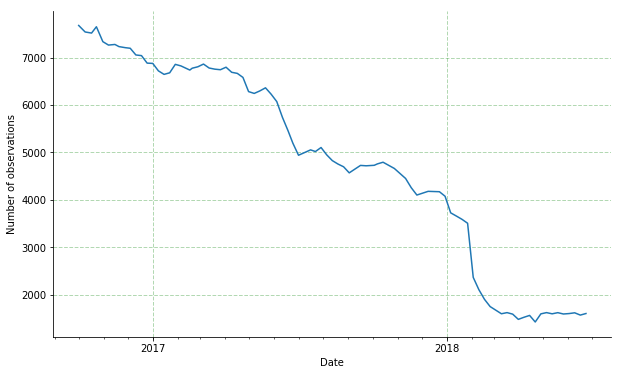

In [5]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
ax.plot(df['date'], df['lines'])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.set_ylabel('Number of observations')
ax.set_xlabel('Date')
ax.grid(color='g', linestyle='--', linewidth=1, alpha=.3)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)  

We conclude that since the begining of the experiment the number of offers in the service has been droping substantially. The biggest drop has been recorded in the begining of 2018 when the number of offers dropped from 4000 to less than 2000. 

The questions remains if this situation is because there are less offers on the market or wether the service is loosing to some other opponent? Unfortunately given this dataset be cannot answer this questions.

# Analyze data


In [6]:
data = []
for idx in df.index:
    read_date = pd.read_json(os.path.join(ddir, df.loc[idx, 'file']), lines=True)
    read_date['date'] = df.loc[idx, 'date']
    data.append(read_date)
    read_date = None

data = pd.concat(data, axis=0)

In [7]:
data.tail()

,_type,data_lat,data_lon,description,details,floor,location,poi_lat,poi_lon,pow,price,rooms,sellType,town,url,date
1604,HomespiderItem,53.413120,14.578210,"[Mieszkanie, 82,60 m², Szczecin]",Polecam na sprzedaż 4 pokojowe mieszkanie o po...,3,"Mieszkanie na sprzedaż, Szczecin, Śródmieście",53.4156,14.577,82.60,350000.0,4,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-82-60-...,2018-06-23
1605,HomespiderItem,53.441479,14.538239,"[Mieszkanie, 132 m², Szczecin]",OFERTA DLA INWESTORA!!! MIESZKANIE JEST WYNAJĘ...,2,"Mieszkanie na sprzedaż, Szczecin, ks. Piotra S...",53.4418,14.5354,132.00,555000.0,5,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-132-m-...,2018-06-23
1606,HomespiderItem,53.432408,14.536559,"[Mieszkanie, 105 m², Szczecin]",Atrakcyjne mieszkanie (aktualnie wykorzystane ...,1,"Mieszkanie na sprzedaż, Szczecin, Centrum, JAG...",53.4328,14.5343,105.00,460000.0,4,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-105-m-...,2018-06-23
1607,HomespiderItem,53.413120,14.578210,"[Mieszkanie, 132 m², Szczecin]",Piękne i przestronne mieszkanie o powierzchni ...,2,"Mieszkanie na sprzedaż, Szczecin, Śródmieście",53.4156,14.577,132.00,525000.0,5,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-132-m-...,2018-06-23
1608,HomespiderItem,53.481732,14.541711,[2 pokoje Apartamenty Warszewo - Szczecin],Wyróżniająca się inwestycja realizowana w prze...,1,"Mieszkanie na sprzedaż, Szczecin, Warszewo, M...",53.4826,14.5453,42.61,249000.0,2,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/2-pokoje-apartame...,2018-06-23


We see that some columns as `_type`, `sellType`, `town` or `url` we won't be needing. The detils column includes the whole description of the offer. Let's see what's inside the data.

In [8]:
data['date'] = pd.to_datetime(data['date'])
data = data.drop(columns=['_type', 'sellType', 'town', 'url'])
data.describe()

,data_lat,data_lon,pow,price
count,413704.000000,413704.000000,413704.000000,4.137040e+05
mean,53.196654,14.488744,68.401310,3.016699e+05
std,3.527650,0.976426,65.261838,1.308628e+05
min,0.000000,0.000000,11.000000,3.900000e+04
25%,53.420000,14.521824,47.740000,2.190000e+05
50%,53.432830,14.546396,62.000000,2.790000e+05
75%,53.445569,14.554006,82.000000,3.530000e+05
max,54.524587,53.221296,6330.000000,6.990000e+06


The average size of offered appartment was 68.4 m$^2$ and the average price was around 300k PLN.

We see that geographical coordinates, area and price are numeric. Apparently the `floor` variable has some non-numeric values.

In [9]:
data['floor'].value_counts()

1           89674
4           78874
2           74595
parter      71983
3           64151
5            9602
6            7014
10           3671
8            3333
> 10         3258
7            3164
9            2437
poddasze      510
4             419
2             252
3             232
1             178
11            120
5              92
10             64
8              27
12             23
6              17
suterena        7
28              6
26              1
Name: floor, dtype: int64

We can see that the ground floor is described as the word `parter`. Also there are some appartments lower than ground floor `suterena`, but we will consider them as ground floor. We also add a category as giving the number of floors as 5 and more and 10 and more.

In [10]:
data.loc[data['floor'] == 'parter', 'floor'] = '0'
data.loc[data['floor'] == 'suterena', 'floor'] = '0'
data.loc[data['floor'] == 'poddasze', 'floor'] = '5'
data.loc[data['floor'] == '> 10', 'floor'] = '11'

data['floor'] = pd.to_numeric(data['floor'])
data.loc[data['floor'] > 10, 'floor'] = 10

data['floor'].value_counts()

1     89852
4     79293
2     74847
0     71990
3     64383
5     10204
10     7143
6      7031
8      3360
7      3164
9      2437
Name: floor, dtype: int64

In [11]:
data['rooms'].value_counts()

3                137132
2                132763
4                 55673
1                 25911
3                 16997
2                 15722
5                 13671
4                  7372
1                  4063
6                  2080
5                  1595
6                   289
7                   233
8                    76
7                    70
9                    32
więcej niż 10        13
8                    12
Name: rooms, dtype: int64

In [12]:
data.loc[data['rooms'] == 'więcej niż 10', 'rooms'] = '10'
data['rooms'] = pd.to_numeric(data['rooms'])
data['rooms'].value_counts()

3     154129
2     148485
4      63045
1      29974
5      15266
6       2369
7        303
8         88
9         32
10        13
Name: rooms, dtype: int64

The floor and room numbers looks fine now. Next we can visualize our data. Also for visualization we will create a sample without duplicates.

First we want to look how does the price depend on the area.

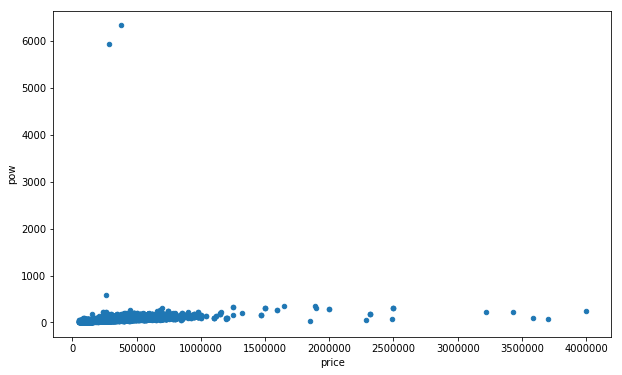

In [13]:
duplicate_verify = ['details', 'location', 'pow', 'floor', 'rooms', 'data_lat', 'data_lon']
sample = ~data.duplicated(duplicate_verify, keep='first')

data[sample].plot.scatter('price', 'pow')

We see that there are some outliers with area greater than 5000 m$^2$. Also We will consider everything priced more than 3M PLN as outliers.

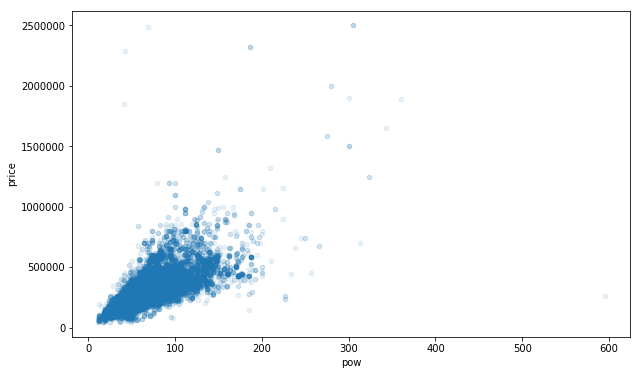

In [14]:
data = data.loc[(data['pow'] < 5000) & (data['price'] < 3e6)]

sample = ~data.duplicated(duplicate_verify, keep='first')

data[sample].plot.scatter('pow', 'price',  alpha=0.1)

There seems to be a lot of varaiance with increasing price. It's good to check the distribution of price and log price. We will once again plot, but with logs this time.

We will also calcuate the log of area.

Text(0.5,0,'Price, log PLN')

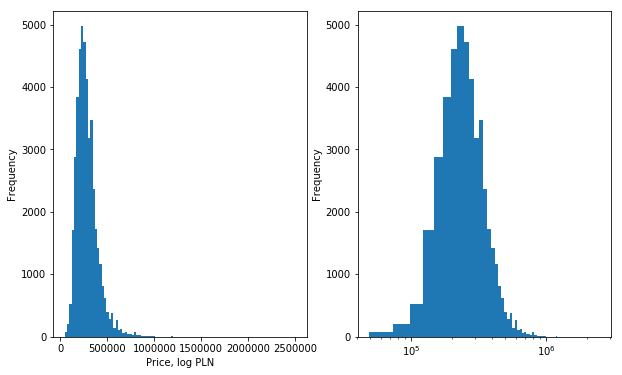

In [15]:
fig , ax= plt.subplots(ncols=2, nrows=1)
data.loc[sample, 'price'].plot.hist(bins=100, ax=ax[0])
ax[0].set_xlabel('Price, PLN')
data.loc[sample, 'price'].plot.hist(bins=100, logx=True, ax=ax[1])
ax[0].set_xlabel('Price, log PLN')

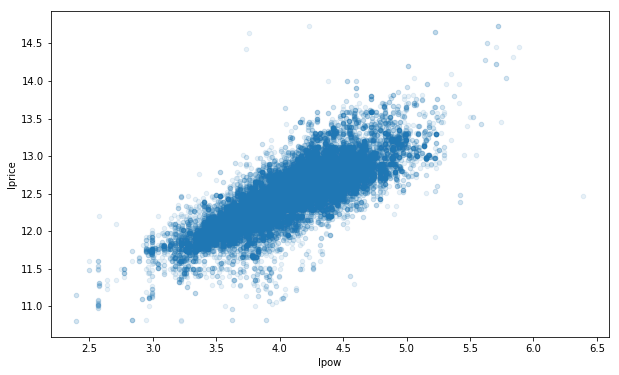

In [16]:
data['lprice'] = np.log(data['price'])
data['lpow'] = np.log(data['pow'])
data[sample].plot.scatter('lpow', 'lprice',  alpha=0.1)

Now let's see how the price, area and price per m$^2$ changed in time.

In [17]:
data['price_m'] = data['price'] / data['pow']

summ_cols = ['date', 'price', 'pow', 'price_m']
time_averages = data[summ_cols].groupby('date').aggregate(np.mean)

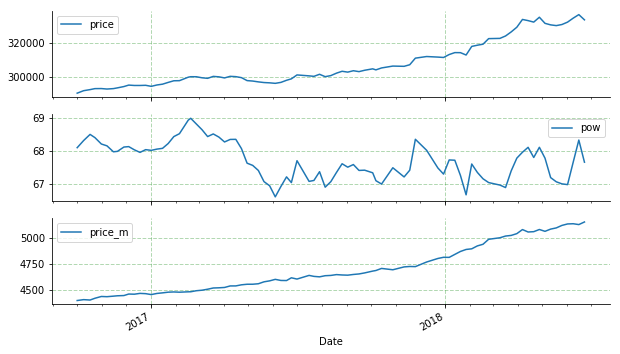

In [18]:
fig , ax= plt.subplots(ncols=1, nrows=3)
time_averages.plot.line(y='price', ax=ax[0])
time_averages.plot.line(y='pow', ax=ax[1])
time_averages.plot.line(y='price_m', ax=ax[2])

for axis in [0, 1, 2]:
    ax[axis].xaxis.set_major_locator(years)
    ax[axis].xaxis.set_major_formatter(yearsFmt)
    ax[axis].xaxis.set_minor_locator(months)
    ax[axis].grid(color='g', linestyle='--', linewidth=1, alpha=.3)
    ax[axis].get_xaxis().tick_bottom()    
    ax[axis].get_yaxis().tick_left()    
    ax[axis].spines["top"].set_visible(False)    
    #ax[axis].spines["bottom"].set_visible(False)    
    ax[axis].spines["right"].set_visible(False)    
    #ax[axis].spines["left"].set_visible(False)   
    if axis < 2:
        ax[axis].set_xticklabels([])
        ax[axis].set_xlabel("")
    else:
        ax[axis].set_xlabel('Date')

In [19]:
time_averages.tail()

,price,pow,price_m
date,,,
2018-05-26,331198.355851,66.996952,5120.528661
2018-06-02,332626.154605,66.974287,5134.696668
2018-06-09,334994.679686,67.655043,5136.716990
2018-06-16,337102.781377,68.329473,5128.648129
2018-06-23,333983.030733,67.655736,5153.752442


We see that the average area does not change much. What we see is that the price rises continously over the analyzed period. 

We also look at how long an advertisment is on average avaliable.

count                      44656
mean     62 days 12:11:11.372268
std      86 days 21:44:14.053819
min              0 days 00:00:00
25%             13 days 00:00:00
50%             22 days 00:00:00
75%             80 days 00:00:00
max            600 days 00:00:00
Name: date, dtype: object


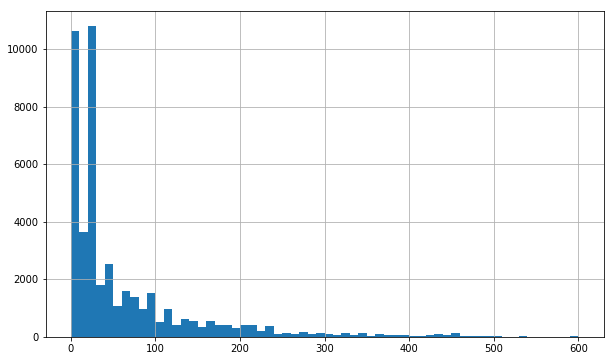

In [20]:
data['group'] = data.groupby(duplicate_verify).grouper.group_info[0]
gr = data.groupby('group')
gr_dur = gr['date'].max() - gr['date'].min()
print(gr_dur.describe())
gr_dur.dt.days.hist(bins=60)

We see that on average an ad is alive for 62 days. The median time recorded is 22 days, around 3 weeks. Unfortunately our data aquisition technique is on 7 day basis, so these results are likely biased. There are also many advertisments with survival time == 0 indicating that before the second run they are already gone.

## Linear regression analysis

Having cleaned our data we can next analyze according to different criteria like area, number of rooms and which floor is the appartment on. For that we will be using `statsmodels` package.

Also we want only to use first occurences for our observations.

In [21]:
import statsmodels.api as sm

In [22]:
sample = ~data.duplicated(duplicate_verify, keep='first')

formula = "price ~ pow"
m0 = sm.OLS.from_formula(formula, data=data[sample]).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                 5.906e+04
Date:                Sun, 22 Jul 2018   Prob (F-statistic):               0.00
Time:                        19:38:06   Log-Likelihood:            -5.6685e+05
No. Observations:               44656   AIC:                         1.134e+06
Df Residuals:                   44654   BIC:                         1.134e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    7.12e+04    954.281     74.612      0.000    6.93e+04    7.31e+04
pow         3378.0062     13.901    243.013      0.000    3350.761    3405.251
==============================================================================
Omnibus:                    37210.605   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7385583.506
Skew:                           3.227   Prob(JB):                         0.00
Kurtosis:                      65.671   Cond. No.                         176.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From this initial regressions results we see that increasing area by 1 m$^2$ increases the price by 3400 PLN. Let's see how this changes when we add floor number and number of rooms. 

We also add localization and length of description.

In [23]:
data['desc_len'] = data['details'].apply(len)

formula = "price ~ pow + floor + rooms + data_lat + data_lon + data_lat * data_lon + desc_len"
m1 = sm.OLS.from_formula(formula, data=data[sample]).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     8836.
Date:                Sun, 22 Jul 2018   Prob (F-statistic):               0.00
Time:                        19:38:06   Log-Likelihood:            -5.6626e+05
No. Observations:               44656   AIC:                         1.133e+06
Df Residuals:                   44648   BIC:                         1.133e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          8.156e+04   4677.697     17.437      0.000    7.24e+04    9.07e+04
pow                2992.2052     22.679    131.937      0.000    2947.754    3036.657
floor             -2087.4060    174.733    -11.946      0.000   -2429.885   -1744.927
rooms              1.277e+04    638.326     19.999      0.000    1.15e+04     1.4e+04
data_lat           8388.3258    885.030      9.478      0.000    6653.653    1.01e+04
data_lon           4.322e+04   5887.291      7.341      0.000    3.17e+04    5.48e+04
data_lat:data_lon -1418.0212    161.247     -8.794      0.000   -1734.067   -1101.975
desc_len              9.5913      0.430     22.314      0.000       8.749      10.434
==============================================================================
Omnibus:                    40183.422   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8630525.874
Skew:                           3.671   Prob(JB):                         0.00
Kurtosis:                      70.709   Cond. No.                     2.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So each subsequent room adds 13k PLN to the price. Also each floor causes price to fall by 2.1k PLN. Also the longer the description the higher the price. Each letter "costs" around 10 PLN ;)

Let's see what happens after adding quarterly price interaction.

In [24]:
data['quarter'] = data['date'].dt.year.apply(str) + \
    "Q" + data['date'].dt.quarter.apply(str)

formula = "price ~ C(quarter) * pow + floor + rooms + data_lat + data_lon + data_lat * data_lon + desc_len + C(quarter)"
m1 = sm.OLS.from_formula(formula, data=data[sample]).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     3383.
Date:                Sun, 22 Jul 2018   Prob (F-statistic):               0.00
Time:                        19:38:07   Log-Likelihood:            -5.6575e+05
No. Observations:               44656   AIC:                         1.132e+06
Df Residuals:                   44636   BIC:                         1.132e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 8.278e+04   4726.956     17.512      0.000    7.35e+04     9.2e+04
C(quarter)[T.2017Q1]      -1.08e+04   2929.445     -3.688      0.000   -1.65e+04   -5062.385
C(quarter)[T.2017Q2]      1.521e+04   3040.620      5.002      0.000    9249.906    2.12e+04
C(quarter)[T.2017Q3]      1.543e+04   3435.341      4.490      0.000    8692.385    2.22e+04
C(quarter)[T.2017Q4]      1.951e+04   3349.957      5.823      0.000    1.29e+04    2.61e+04
C(quarter)[T.2018Q1]       1.92e+04   3747.770      5.124      0.000    1.19e+04    2.65e+04
C(quarter)[T.2018Q2]      5938.5243   4241.107      1.400      0.161   -2374.117    1.43e+04
pow                       2999.0512     26.167    114.613      0.000    2947.764    3050.338
C(quarter)[T.2017Q1]:pow   140.1319     42.391      3.306      0.001      57.045     223.219
C(quarter)[T.2017Q2]:pow  -229.6394     45.950     -4.998      0.000    -319.702    -139.577
C(quarter)[T.2017Q3]:pow  -122.5007     52.071     -2.353      0.019    -224.560     -20.441
C(quarter)[T.2017Q4]:pow    -7.6041     50.029     -0.152      0.879    -105.661      90.453
C(quarter)[T.2018Q1]:pow   113.3219     56.056      2.022      0.043       3.452     223.192
C(quarter)[T.2018Q2]:pow   481.7433     62.716      7.681      0.000     358.820     604.667
floor                    -2091.4323    172.887    -12.097      0.000   -2430.293   -1752.571
rooms                     1.279e+04    634.394     20.167      0.000    1.16e+04     1.4e+04
data_lat                  8184.5918    875.291      9.351      0.000    6469.007    9900.176
data_lon                   4.32e+04   5822.178      7.419      0.000    3.18e+04    5.46e+04
data_lat:data_lon        -1411.4768    159.469     -8.851      0.000   -1724.039   -1098.915
desc_len                     7.5511      0.461     16.390      0.000       6.648       8.454
==============================================================================
Omnibus:                    40046.137   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8683522.715
Skew:                           3.646   Prob(JB):                         0.00
Kurtosis:                      70.924   Cond. No.                     2.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here we can observe that the price per m$^2$ dependency is increasing in the last two quarters when compared to 2016Q4.

Being curious we also want to see how does the time that an advertisement spends online depend on our independent variables.

In [31]:
life = gr_dur.reset_index()
life = life.rename(columns={'date':'life'})
life['life'] = life['life'].dt.days

data = data.merge(life, how='left', left_on='group', right_on='group')

data['price_k'] = data['price'] / 1e3

sample = ~data.duplicated(duplicate_verify, keep='first')
formula = "life ~ price_k + pow + floor + rooms + data_lat + data_lon + data_lat * data_lon + desc_len"
m1 = sm.OLS.from_formula(formula, data=data[sample]).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   life   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     132.2
Date:                Sun, 22 Jul 2018   Prob (F-statistic):          2.12e-220
Time:                        19:45:41   Log-Likelihood:            -2.6222e+05
No. Observations:               44656   AIC:                         5.245e+05
Df Residuals:                   44647   BIC:                         5.245e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.4724      5.184      1.056      0.291      -4.689      15.633
price_k               0.0258      0.005      4.940      0.000       0.016       0.036
pow                   0.4589      0.030     15.539      0.000       0.401       0.517
floor                -0.2134      0.193     -1.104      0.270      -0.592       0.165
rooms                -3.5480      0.708     -5.010      0.000      -4.936      -2.160
data_lat             -1.6609      0.979     -1.697      0.090      -3.579       0.257
data_lon            -12.2019      6.507     -1.875      0.061     -24.955       0.551
data_lat:data_lon     0.3760      0.178      2.109      0.035       0.027       0.725
desc_len              0.0042      0.000      8.820      0.000       0.003       0.005
==============================================================================
Omnibus:                    22103.063   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           128072.547
Skew:                           2.391   Prob(JB):                         0.00
Kurtosis:                       9.780   Cond. No.                     2.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Quick look on the coefficients sugests that the bigger the house and the more expensive it is the longer it stayed on the website. Also the more rooms a house had the quicker it had gone. The effect of geographical position is big, but not significantly different from 0.

Also the longer the description, the longer an ad stayed on the website.

The R$^2$ of this model is really low indicating that most of what we record is noise and this model does not explain this dependance in a good way. 